In [21]:
import numpy as np
import pandas as pd
from fullfrlm import flow_refueling_location_model
import pickle
import networkx as nx
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))

In [22]:
df_h

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490,8866686
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000,8861625
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667,8866425
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667,8864005
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667,8863360
...,...,...,...,...,...,...,...,...,...,...
65,80378,NL,WTE,West-Terschelling,1-------,nan,NLWTE,53.362705,5.216893,8865605
66,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667,8866889
67,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199,8866889
68,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272,8865003


,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490,8866686
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000,8861625
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667,8866425
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667,8864005
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667,8863360
...,...,...,...,...,...,...,...,...,...,...
65,80378,NL,WTE,West-Terschelling,1-------,nan,NLWTE,53.362705,5.216893,8865605
66,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667,8866889
67,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199,8866889
68,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272,8865003


In [23]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, flows = flow_refueling_location_model(1, 50000, 100, 5, 5, 30, vis=False)

Optimal
Optimal


In [24]:
nodes = []
for route in non_zero_flows.keys():
    nodes += paths[route]

nodes = list(set(nodes))

G = G.subgraph(nodes)

In [25]:
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [26]:
df_nodes = df_nodes.loc[df_nodes.index.isin(nodes)]

In [27]:
df_nodes.fillna(0, inplace=True)
df_nodes['model_type'] =df_nodes.n.apply(lambda x: "harbour" if ((len(str(x))>4) and (x in df_h.harbour_node.unique())) else x)
df_nodes.model_type = df_nodes.model_type.apply(lambda x: "inserted_node" if x==0 else x)
df_nodes.model_type = df_nodes.model_type.apply(lambda x: "intermediate_node" if str(x).isdigit() else x)

In [28]:
def cs_harbour_or_both(col1, col2):
    to_r = col2
    if col1 !=0:
        if col2 == 'inserted_node':
            to_r = 'charging_station'
        else:
            to_r = 'harbour_with_charging'
    return to_r


def gen_link_name(col1, col2):
    return tuple([col1, col2])


def find_middle_x(val1, val2):
    x1 = df_nodes.loc[df_nodes.name == val1].X.item()
    x2 = df_nodes.loc[df_nodes.name == val2].X.item()
    return (x1+x2)/2


def find_middle_y(val1, val2):
    y1 = df_nodes.loc[df_nodes.name == val1].Y.item()
    y2 = df_nodes.loc[df_nodes.name == val2].Y.item()
    return (y1+y2)/2

In [29]:
df_nodes['index1'] = df_nodes.index
df_nodes['charging_stations'] = df_nodes.index1.apply(lambda x: optimal_facilities[x] if (x in df_h.harbour_node.unique()) or (len(str(x)) == 3) else 0)
df_nodes.model_type = df_nodes.apply(lambda x: cs_harbour_or_both(x.charging_stations, x.model_type), axis=1)
df_nodes.drop(columns=['index1', 'n', 'geometry', 'Wkt'], inplace=True)

In [30]:
df_nodes.reset_index(inplace=True)
df_nodes.rename(columns={'index':'name'}, inplace=True)
df_nodes['source'] = np.nan
df_nodes['target'] = np.nan
df_nodes['length_m'] = np.nan

In [31]:
df_links = nx.to_pandas_edgelist(G)

In [32]:
df_links = df_links.loc[:, ['source', 'target', 'length_m']]
df_links['X'] = df_links.apply(lambda x: find_middle_x(x.source, x.target), axis=1)
df_links['Y'] = df_links.apply(lambda x: find_middle_y(x.source, x.target), axis=1)
df_links['name'] = df_links.apply(lambda x: gen_link_name(x.source, x.target), axis=1)
df_links['charging_stations'] = np.nan
df_links['model_type'] = 'link'

In [33]:
df_links

,source,target,length_m,X,Y,name,charging_stations,model_type
0,130,8861687,16217.054545,5.754862,51.873656,"(130, 8861687)",NaN,link
1,130,8865412,16217.054545,5.610598,51.889376,"(130, 8865412)",NaN,link
2,8864005,8864076,6879.517933,5.224707,52.422808,"(8864005, 8864076)",NaN,link
3,8864005,8864526,28128.831078,5.353220,52.434577,"(8864005, 8864526)",NaN,link
4,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link
...,...,...,...,...,...,...,...,...
88,8864526,8862690,7646.120619,5.495998,52.483369,"(8864526, 8862690)",NaN,link
89,8867374,8867500,2903.957469,4.578663,51.908201,"(8867374, 8867500)",NaN,link
90,8865140,8867500,4548.711456,4.599769,51.895772,"(8865140, 8867500)",NaN,link
91,8863614,8867395,798.550864,6.932619,53.328262,"(8863614, 8867395)",NaN,link


,source,target,length_m,X,Y,name,charging_stations,model_type
0,130,8861687,16217.054545,5.754862,51.873656,"(130, 8861687)",NaN,link
1,130,8865412,16217.054545,5.610598,51.889376,"(130, 8865412)",NaN,link
2,8864005,8864076,6879.517933,5.224707,52.422808,"(8864005, 8864076)",NaN,link
3,8864005,8864526,28128.831078,5.353220,52.434577,"(8864005, 8864526)",NaN,link
4,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link
...,...,...,...,...,...,...,...,...
86,8867374,8867500,2903.957469,4.578663,51.908201,"(8867374, 8867500)",NaN,link
87,8865140,8867500,4548.711456,4.599769,51.895772,"(8865140, 8867500)",NaN,link
88,8863614,8867395,798.550864,6.932619,53.328262,"(8863614, 8867395)",NaN,link
89,8867785,8862614,4541.701592,3.686130,51.429357,"(8867785, 8862614)",NaN,link


In [34]:
df_abm = pd.concat([df_links, df_nodes])
df_abm.reset_index(inplace=True)
df_abm.rename(columns={'index':'id'}, inplace=True)

In [35]:
df_abm

,id,source,target,length_m,X,Y,name,charging_stations,model_type
0,0,130,8861687,16217.054545,5.754862,51.873656,"(130, 8861687)",NaN,link
1,1,130,8865412,16217.054545,5.610598,51.889376,"(130, 8865412)",NaN,link
2,2,8864005,8864076,6879.517933,5.224707,52.422808,"(8864005, 8864076)",NaN,link
3,3,8864005,8864526,28128.831078,5.353220,52.434577,"(8864005, 8864526)",NaN,link
4,4,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link
...,...,...,...,...,...,...,...,...,...
185,92,NaN,NaN,NaN,3.668687,51.439072,8862614,0.0,intermediate_node
186,93,NaN,NaN,NaN,5.896942,51.163889,8864319,0.0,intermediate_node
187,94,NaN,NaN,NaN,4.832089,52.431155,8866889,0.0,harbour
188,95,NaN,NaN,NaN,4.752853,52.632750,8861625,1.0,harbour_with_charging


,id,source,target,length_m,X,Y,name,charging_stations,model_type
0,0,130,8861687,16217.054545,5.754862,51.873656,"(130, 8861687)",NaN,link
1,1,130,8865412,16217.054545,5.610598,51.889376,"(130, 8865412)",NaN,link
2,2,8864005,8864076,6879.517933,5.224707,52.422808,"(8864005, 8864076)",NaN,link
3,3,8864005,8864526,28128.831078,5.353220,52.434577,"(8864005, 8864526)",NaN,link
4,4,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link
...,...,...,...,...,...,...,...,...,...
180,89,NaN,NaN,NaN,5.896942,51.163889,8864319,0.0,intermediate_node
181,90,NaN,NaN,NaN,4.832089,52.431155,8866889,2.0,harbour_with_charging
182,91,NaN,NaN,NaN,4.752853,52.632750,8861625,1.0,harbour_with_charging
183,92,NaN,NaN,NaN,5.525170,52.500915,8862690,0.0,intermediate_node


Optimal


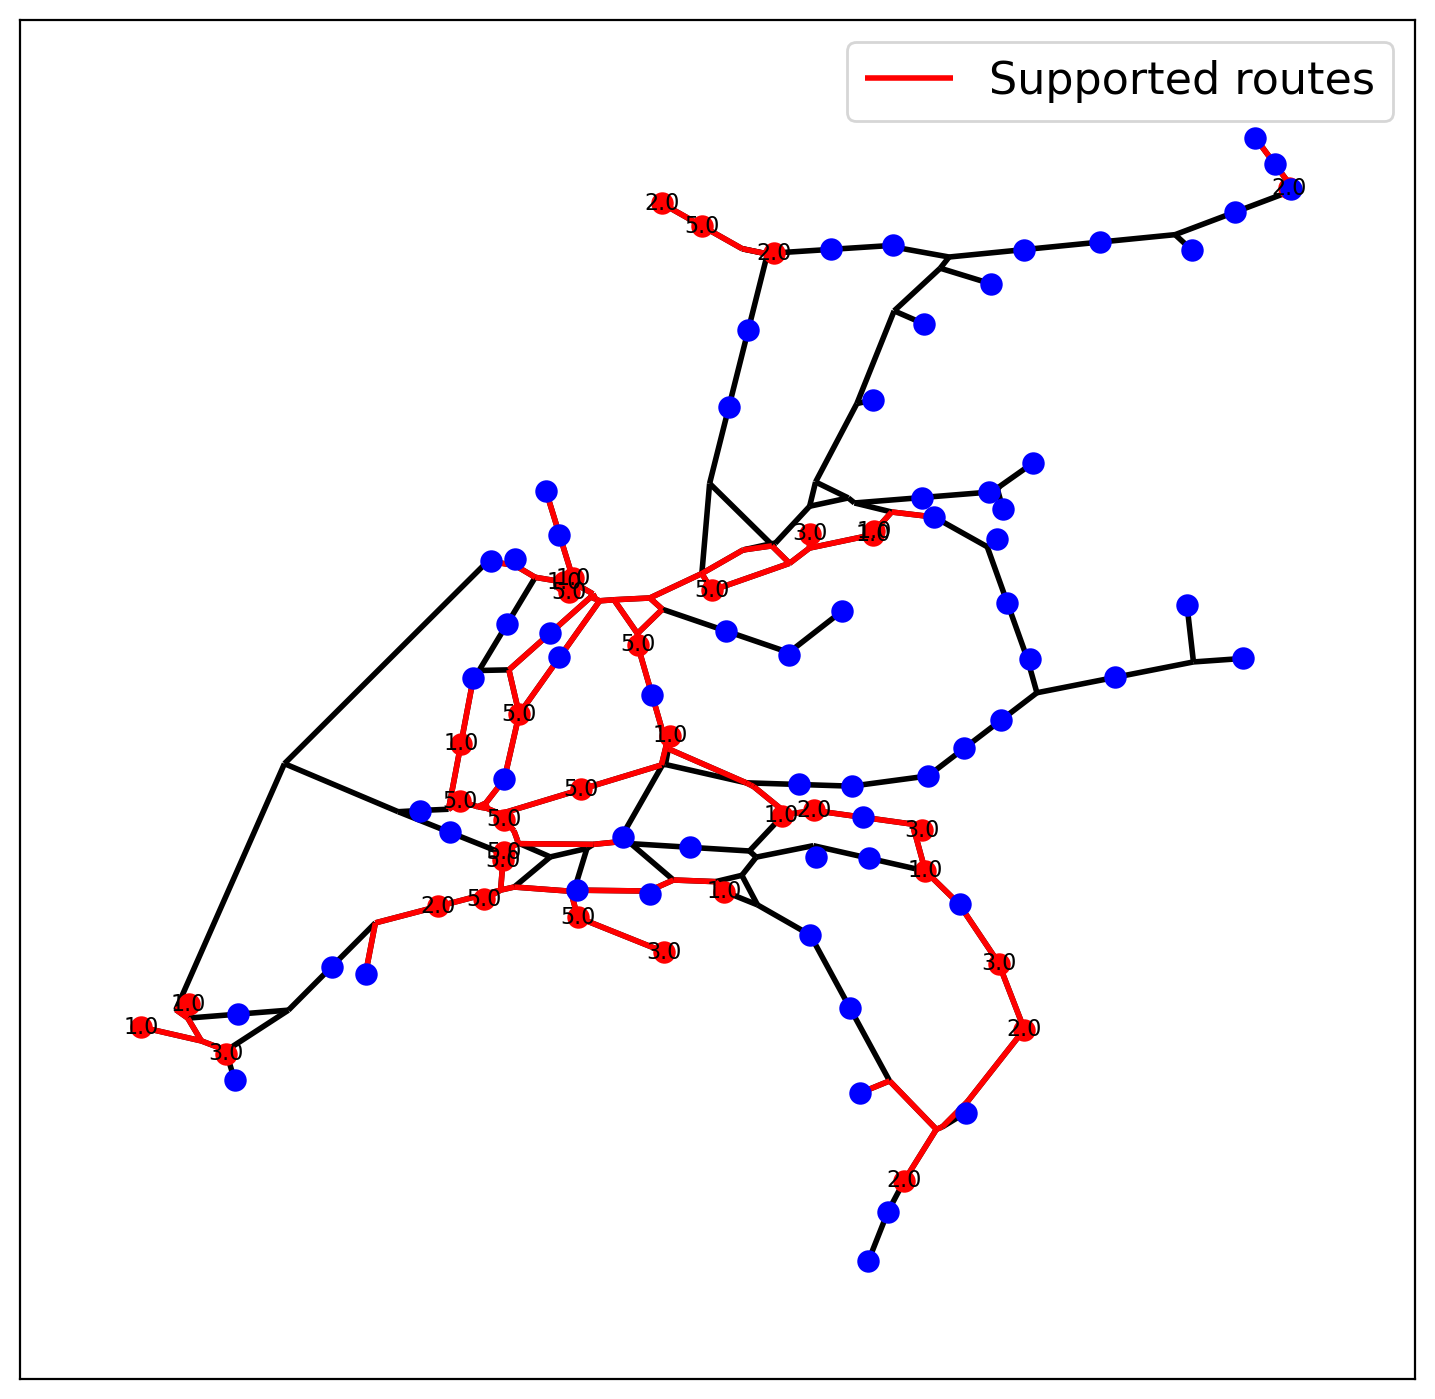

Optimal


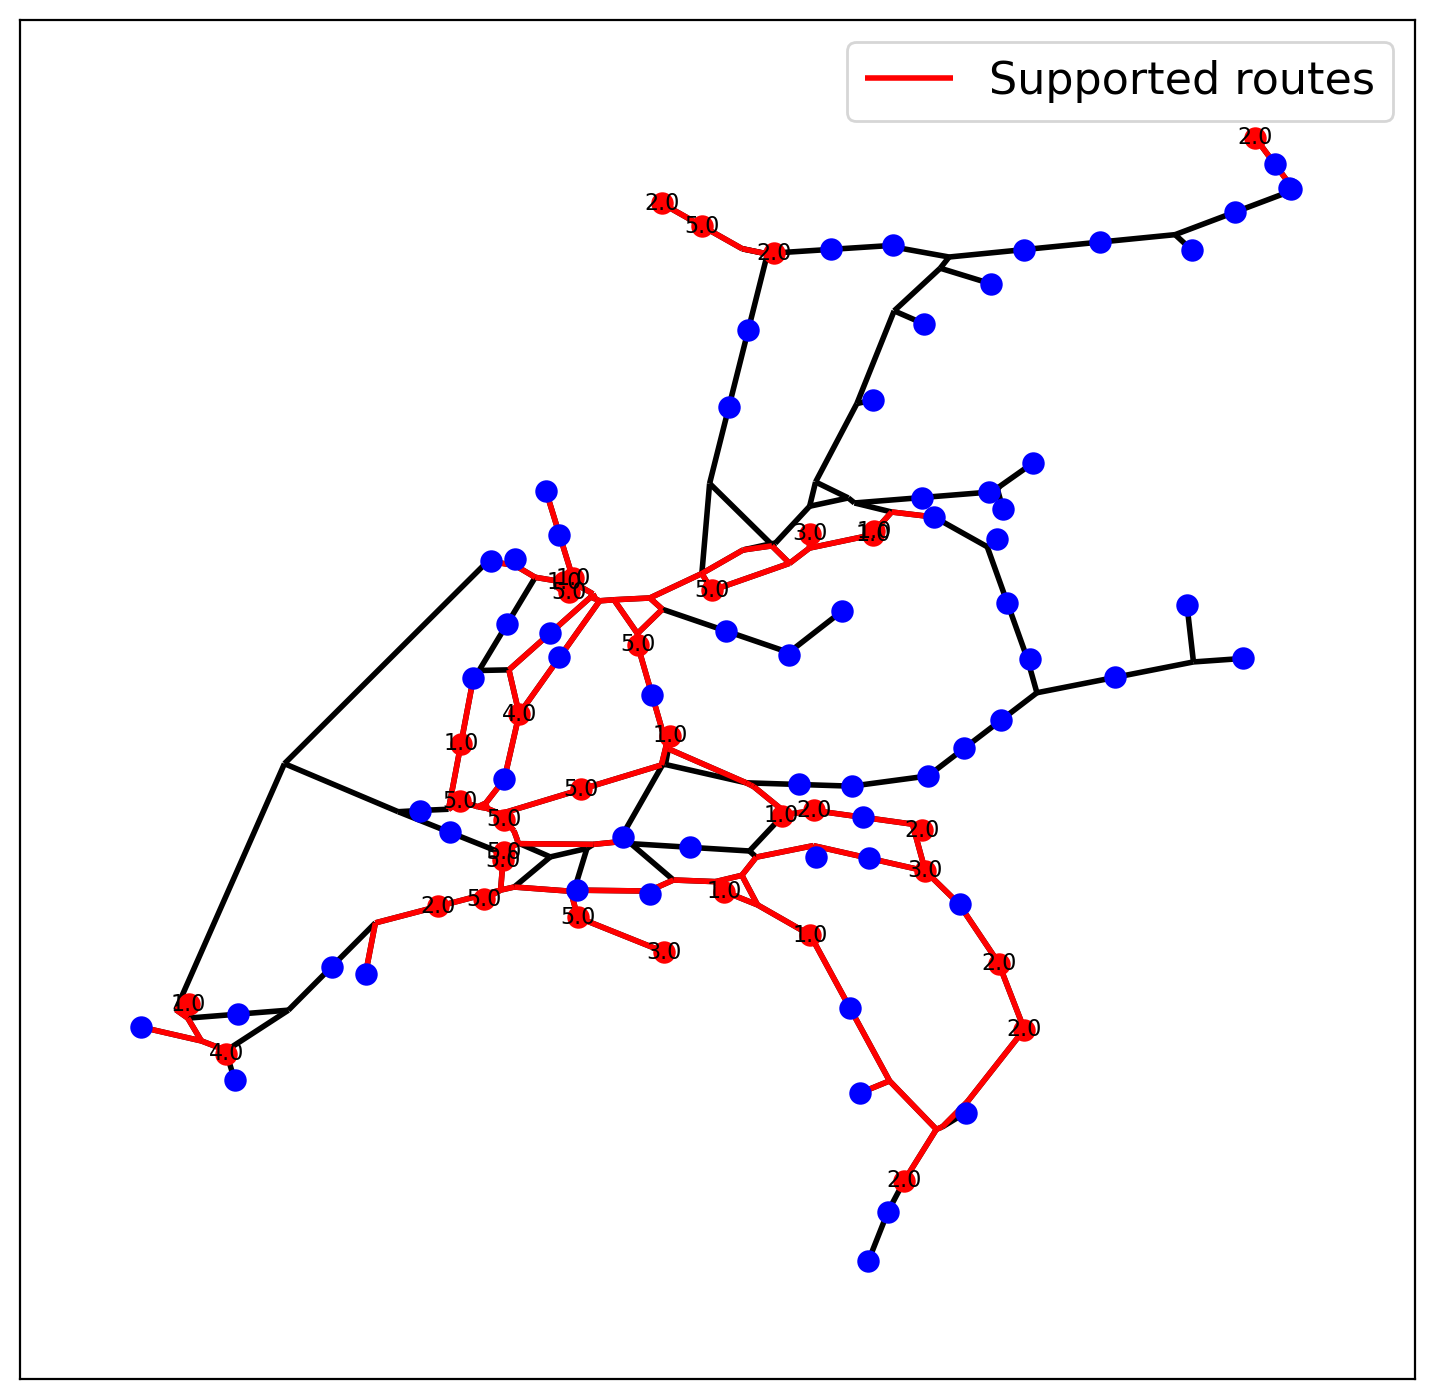

In [36]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, flows = flow_refueling_location_model(1, 100000, 100, 5, 5, 30, vis=True)

In [37]:
df_abm

,id,source,target,length_m,X,Y,name,charging_stations,model_type
0,0,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link
1,1,30986055,8865756,2481.139176,5.412350,53.178500,"(30986055, 8865756)",NaN,link
2,2,8866889,8863272,1818.196908,4.836342,52.424633,"(8866889, 8863272)",NaN,link
3,3,8866889,131,16028.479775,4.812280,52.481554,"(8866889, 131)",NaN,link
4,4,30984595,8860725,6279.201491,4.596294,51.703364,"(30984595, 8860725)",NaN,link
...,...,...,...,...,...,...,...,...,...
239,116,NaN,NaN,NaN,6.888270,53.384504,122,0.0,inserted_node
240,117,NaN,NaN,NaN,4.764483,52.304545,125,0.0,inserted_node
241,118,NaN,NaN,NaN,5.682730,51.881516,130,0.0,inserted_node
242,119,NaN,NaN,NaN,4.792471,52.531953,131,0.0,inserted_node


,id,source,target,length_m,X,Y,name,charging_stations,model_type
0,0,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link
1,1,30986055,8865756,2481.139176,5.412350,53.178500,"(30986055, 8865756)",NaN,link
2,2,11309058,8865990,18936.187403,5.450226,51.645417,"(11309058, 8865990)",NaN,link
3,3,11309058,8866775,11560.215727,5.324146,51.695530,"(11309058, 8866775)",NaN,link
4,4,11309058,11309119,9235.019525,5.349926,51.714149,"(11309058, 11309119)",NaN,link
...,...,...,...,...,...,...,...,...,...
258,124,NaN,NaN,NaN,6.888270,53.384504,122,0.0,inserted_node
259,125,NaN,NaN,NaN,4.764483,52.304545,125,0.0,inserted_node
260,126,NaN,NaN,NaN,5.682730,51.881516,130,0.0,inserted_node
261,127,NaN,NaN,NaN,4.792471,52.531953,131,0.0,inserted_node


In [38]:
df_abm.model_type.unique()

array(['link', 'intermediate_node', 'harbour_with_charging', 'harbour',
       'charging_station', 'inserted_node'], dtype=object)

array(['link', 'intermediate_node', 'harbour_with_charging', 'harbour',
       'charging_station', 'inserted_node'], dtype=object)

In [39]:
pickle.dump(G, open("ABM/own_work/data/network.p", "wb"))
pickle.dump(paths, open("ABM/own_work/data/paths.p", "wb"))
pickle.dump(flows, open("ABM/own_work/data/total_flow.p", "wb"))
pickle.dump(df_abm, open("ABM/own_work/data/df_abm.p", "wb"))

In [40]:
df_abm.to_csv('ABM/own_work/data/df_abm.csv')